In [45]:
from ngsolve import *
from ngsolve.meshes import MakeQuadMesh
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix

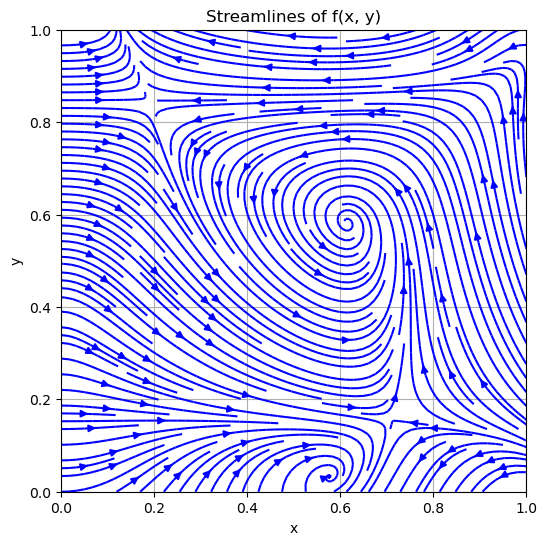

In [46]:
def f(x, y):
    f1 = -(12*x**2 - 12*x + 2)*(2*y - 8*y**3 +6*y**5) - (x**4 - 2*x**3 + x**2)*(-48*y + 120*y**3) + 1 - 2*x
    f2 = -(-2 + 12*y - 12*y**2)*(2*x - 8*x**3 + 6*x**5) - (-y**2 + 2*y**3 - y**4)*(-48*x + 120*x**3)
    return f1, f2

n = 100
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

F1, F2 = f(X, Y)

plt.figure(figsize=(6, 6))
plt.streamplot(X, Y, F1, F2, color='blue', density=2)
plt.title("Streamlines of f(x, y)")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('tight')
plt.grid(True)
plt.show()

In [67]:
n = 64
lam = 1.0

[0. 0. 0. ... 0. 0. 0.]


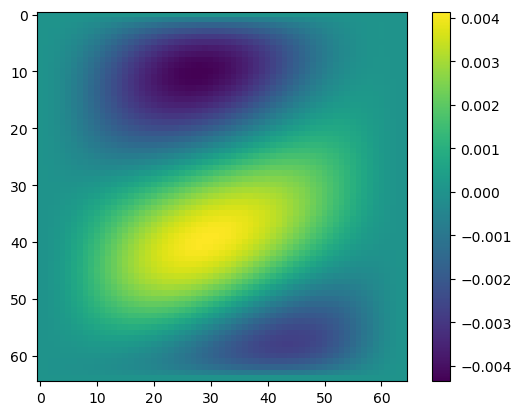

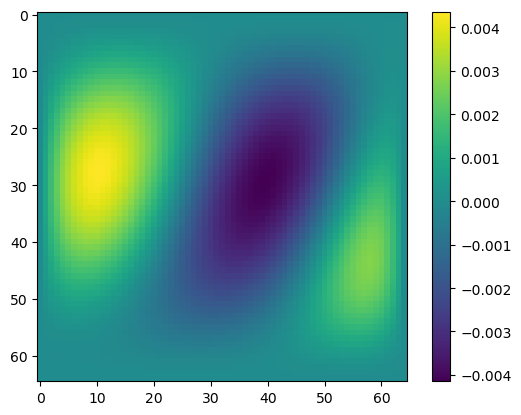

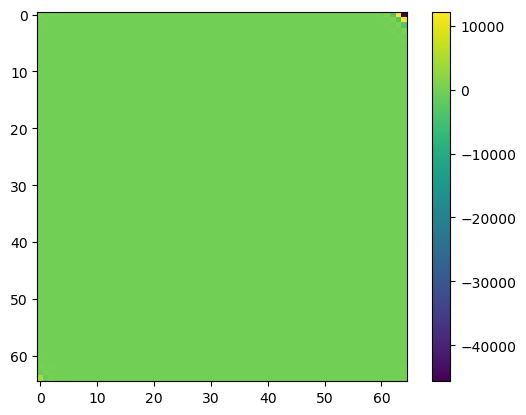

In [77]:
mesh = MakeQuadMesh(n, n)

V = VectorH1(mesh, order=1, dirichlet=".*")
Q = H1(mesh, order=1)

X = V*Q

u, p = X.TrialFunction()
v, q = X.TestFunction()

stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes).Assemble()

# Exact solutions
u1_exact = x**2*(1-x)**2*(2*y-8*y**3+6*y**5)
u2_exact = -y**2*(1-y)**2*(2*x-8*x**3+6*x**5)
p_exact = x*(1-x)

# Set boundary conditions
gfu = GridFunction(X)
gfu.components[0].Set(CoefficientFunction((u1_exact, u2_exact)), definedon=mesh.Boundaries(".*"))
print(gfu.components[0].vec.FV().NumPy())

# Right hand side
f1 = -(u1_exact.Diff(x, 2) + u1_exact.Diff(y, 2)) + p_exact.Diff(x)
f2 = -(u2_exact.Diff(x, 2) + u2_exact.Diff(y, 2)) + p_exact.Diff(y)
f = CoefficientFunction((f1, f2))

l = LinearForm(X)
l += InnerProduct(f, v)*dx
l.Assemble()

# Solve
inv = a.mat.Inverse(X.FreeDofs())
gfu.vec.data = inv * l.vec

vel_x = gfu.vec.FV().NumPy()[:(n+1)**2]
vel_y = gfu.vec.FV().NumPy()[(n+1)**2:2*(n+1)**2]
p = gfu.vec.FV().NumPy()[2*(n+1)**2:]

plt.imshow(vel_x.reshape((n+1, n+1)))
plt.colorbar()
plt.show()

plt.imshow(vel_y.reshape((n+1, n+1)))
plt.colorbar()
plt.show()

plt.imshow(p.reshape((n+1, n+1)))
plt.colorbar()
plt.show()

In [22]:
mesh = MakeQuadMesh(n, n)

V = ngs.VectorH1(mesh, order=1)
Q = ngs.H1(mesh, order=1)

X = V*Q

u, p = X.TrialFunction()
v, q = X.TestFunction()

a = ngs.BilinearForm(X)
a += ngs.InnerProduct(ngs.grad(u), ngs.grad(v))*ngs.dx
a += -ngs.div(v)*p*ngs.dx
a += -ngs.div(u)*q*ngs.dx
a += (1/lam)*p*q*ngs.dx

f = ngs.LinearForm(X)
f += ngs.x * v[0] * ngs.dx + ngs.y * v[1] * ngs.dx  # example RHS

a.Assemble()
f.Assemble()